In [1]:
# !pip install pandas
# !pip install matplotlib
# !pip install plotly
# !pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from itertools import product
from collections import defaultdict
import json
import ast
import csv
from IPython.display import display
import time

In [2]:
def finding_days_users_less_than_2hrs_records_groupto(df):
    all_users_days_df = df.copy()
    all_users_days_df['date'] = all_users_days_df.apply(lambda x : x.cleaned_UTC_time.date(), axis=1)
    all_users_unique_days_df = all_users_days_df.groupby('user_id')['date'].nunique().reset_index(name='counts')
    all_users_unique_days_df = all_users_unique_days_df.sort_values(by=['counts'])
    return all_users_unique_days_df

## PrefixSpan experiment  to collect user mobility

In [3]:
new_nyc_df = pd.read_csv('cleaned_NYC_records_7_categories_updated_duration.csv')
#new_nyc_df['cleaned_UTC_time'] = pd.to_datetime(new_nyc_df["UTC_time"])
new_nyc_df['cleaned_UTC_time'] = pd.to_datetime(new_nyc_df["UTC_time"], format='%a %b %d %H:%M:%S %z %Y')

less_equal_2hours_df = new_nyc_df[(new_nyc_df.duration <= 2) & (new_nyc_df.duration != -1)]

months = [4, 5, 6]
less_than_2hrs_3months_df = less_equal_2hours_df.copy()
less_than_2hrs_3months_df.loc[:, 'month'] = less_than_2hrs_3months_df['cleaned_UTC_time'].dt.month
less_than_2hrs_3months_df = less_than_2hrs_3months_df[less_than_2hrs_3months_df['month'].isin(months)]


In [4]:
user_days_df = finding_days_users_less_than_2hrs_records_groupto(less_than_2hrs_3months_df)
frequent_users_df = user_days_df[user_days_df['counts'] >= 50]

In [5]:
user_set_df = less_than_2hrs_3months_df[less_than_2hrs_3months_df.user_id.isin(frequent_users_df.user_id)]

# E, O, Out, Edu(Edu, R), Sh(Sh, Ser), Ent(A, Ex, Ent), F

# Eateries - E
# Shops - Sh
# Education - Edu
# Outdoor - Out
# Entertainment - Ent
# Fitness - F
# Others - O

general_categories_tags_dict = {
        'Eateries': 'E',
        'Shops': 'Sh',
        'Education': 'Edu',
        'Outdoor': 'Out',
        'Entertainment': 'Ent',
        'Fitness': 'F',
        'Others': 'O'
    }

def generate_general_categories_tags(row):
    return general_categories_tags_dict[row['general_venue_category_name']]

#user_set_df['general_venue_category_tag'] = user_set_df.apply(generate_general_categories_tags, axis=1)

user_set_df = user_set_df.copy()  # ensures it's a real copy, not a view
user_set_df['general_venue_category_tag'] = user_set_df.apply(generate_general_categories_tags, axis=1)


In [6]:
subsequence_all_7categories_df = user_set_df.copy()
subsequence_all_7categories_df['date'] = subsequence_all_7categories_df.apply(lambda x : x.cleaned_UTC_time.date(), axis=1)
subsequence_all_7categories_df = subsequence_all_7categories_df.groupby(['user_id', 'date'])['general_venue_category_tag'].apply(lambda x: list(x)).reset_index(name='category_set')
subsequence_all_7categories_df['counts'] = subsequence_all_7categories_df['category_set'].apply(lambda x: len(x))

In [7]:
def mine_rec(patt, mdb, db, results, minsup):
    def localOccurs(mdb):
        occurs = defaultdict(list)

        # The stoppos is always start with 1, and 1 represents the 0th index element in the sequence
        for (i, stoppos) in mdb:
            seq = db[i]
            for j in range(stoppos, len(seq)):
                l = occurs[seq[j]]
                if len(l) == 0 or l[-1][0] != i:
                    l.append((i, j + 1))

        return occurs

    for (c, newmdb) in localOccurs(mdb).items():
        newsup = len(newmdb)

        if newsup >= minsup:
            newpatt = patt + [c]

            results.append((newpatt, [i for (i, stoppos) in newmdb]))
            mine_rec(newpatt, newmdb, db, results, minsup)
            
def mine_specific_user_rec(df, user_id, support_percentage):
    db = np.array(df[(df.user_id == user_id)].category_set)
    minsup = np.floor(len(db) * support_percentage)
    results = []
    
    mine_rec([], [(i, 0) for i in range(len(db))], db, results, minsup)
    return results

#### Global clock implementation

In [8]:
def global_clock_implementation(number_of_categories, user_id, support_percentage):
    if number_of_categories == 7:
        user_seq_results = mine_specific_user_rec(subsequence_all_7categories_df, user_id, support_percentage)
    elif number_of_categories == 10:
        user_seq_results = mine_specific_user_rec(subsequence_all_df, user_id, support_percentage)
    else:
        user_seq_results = mine_specific_user_rec(subsequence_all_13categories_df, user_id, support_percentage)
        
    max_length = 0
    for i in user_seq_results:
        if len(i[0]) > max_length:
            max_length = len(i[0])
        
    user_seq_record = [{} for i in range(max_length)]
    
    for i in user_seq_results:
        for j in range(len(i[0])):
            if len(i[0]) >= j:
                key = i[0][j]
                if key not in user_seq_record[j]:
                    user_seq_record[j][key] = len(i[1])
                else:
                    user_seq_record[j][key] = user_seq_record[j][key] + len(i[1])
    
    for i in range(len(user_seq_record)):
        total_frequencies = sum(user_seq_record[i].values())
        for k, v in user_seq_record[i].items():
             user_seq_record[i][k] = round(v / total_frequencies, 2)
            
    return user_seq_record
    

In [9]:
## To encode the probabilistic patterns
def encode_probabilistic_patterns(patterns_list, patterns_file):
    f = open(patterns_file, 'w', newline='')

    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    for pattern in patterns_list:
        values_str = [json.dumps(i) for i in pattern]
        writer.writerow(values_str)

    # close the file
    f.close()

## To decode the probabilistic patterns
def decode_probabilistic_patterns(patterns_file):
    patterns_list = []
    
    f = open(patterns_file, 'r')
    
    reader = csv.reader(f)
    
    for row in reader:
        values = [ast.literal_eval(i) for i in row]
        
        if len(values) > 0:
            patterns_list.append(values)
        
    f.close()
    
    return patterns_list

In [10]:
def write_probabilistic_patterns_csv(number_of_categories, support_threshold):
    patterns_list = []
    
    for user_id in frequent_users_df.user_id:
        patterns_list.append(global_clock_implementation(number_of_categories, user_id, support_threshold))
        
    encode_probabilistic_patterns(patterns_list, "{}_{}_probabilistic_patterns.csv".format(support_threshold, number_of_categories))

In [11]:
write_probabilistic_patterns_csv(7, 0.5)

In [12]:
patterns_list = decode_probabilistic_patterns("0.5_7_probabilistic_patterns.csv")
print(patterns_list)

[[{'O': 0.76, 'E': 0.24}, {'O': 0.68, 'E': 0.32}, {'O': 0.67, 'E': 0.33}], [{'O': 0.34, 'E': 0.48, 'Sh': 0.18}, {'E': 0.47, 'O': 0.31, 'Sh': 0.22}, {'O': 0.34, 'E': 0.43, 'Sh': 0.23}, {'O': 0.33, 'E': 0.67}], [{'Sh': 0.51, 'O': 0.49}, {'O': 1.0}], [{'Out': 0.33, 'O': 0.67}, {'O': 0.8, 'Out': 0.2}, {'O': 1.0}], [{'E': 1.0}, {'E': 1.0}, {'E': 1.0}], [{'Sh': 0.38, 'E': 0.32, 'Edu': 0.3}], [{'O': 0.77, 'Sh': 0.23}, {'O': 1.0}], [{'O': 0.49, 'Sh': 0.51}], [{'E': 0.57, 'O': 0.43}], [{'O': 1.0}], [{'O': 1.0}], [{'E': 0.53, 'O': 0.47}], [{'E': 0.48, 'Sh': 0.34, 'O': 0.18}, {'E': 0.33, 'Sh': 0.32, 'O': 0.35}], [{'Sh': 0.51, 'E': 0.49}], [{'E': 0.55, 'Sh': 0.21, 'O': 0.24}, {'Sh': 0.21, 'E': 0.67, 'O': 0.12}, {'E': 0.72, 'Sh': 0.24, 'O': 0.04}, {'E': 0.82, 'Sh': 0.18}, {'E': 0.81, 'Sh': 0.19}, {'E': 1.0}], [{'O': 0.44, 'E': 0.56}], [{'O': 0.38, 'Sh': 0.19, 'Out': 0.22, 'E': 0.21}, {'E': 1.0}], [{'O': 1.0}], [{'Sh': 0.86, 'O': 0.14}, {'Sh': 0.8, 'O': 0.2}, {'Sh': 1.0}, {'Sh': 1.0}], [{'E': 0.26, 

#### Experiment 1 (Threshold vs number of sequences): 

In [13]:
def calculating_number_of_sequences_found(df, frequent_users_df, support_percentage):
    result_df = pd.DataFrame(columns=['user_id', 'number_of_sequences'])
    
    for user_id in frequent_users_df.user_id:
        user_df = pd.DataFrame(columns=['sequence', 'length', 'support'])
        user_result_df = mine_specific_user_rec(df, user_id, support_percentage)
        
        for i in user_result_df:
            user_new_record_row = {'sequence': i[0], 'length': len(i[0]), 'support': len(i[1])}
            #user_df = user_df.append(user_new_record_row, ignore_index=True)
            user_df = pd.concat([user_df, pd.DataFrame([user_new_record_row])], ignore_index=True)

            
        if np.isnan(user_df.length.mean()):
            avg_length = 0
        else:
            avg_length = user_df.length.mean()
            
        if np.isnan(user_df.support.mean()):
            avg_support = 0
        else:
            avg_support = user_df.support.mean()
            
        new_row = {'user_id': user_id, 'number_of_sequences': user_df.shape[0], 'avg_length': avg_length,
                   'avg_support': avg_support}
       # result_df = result_df.append(new_row, ignore_index=True)
        result_df = pd.concat([result_df, pd.DataFrame([new_row])], ignore_index=True)

    return result_df

In [14]:
def prefixSpan_threshold_change(number_of_category):
    thresholds = [0.25, 0.5, 0.75]
    number_of_sequences = []
    length = []
    

    df = subsequence_all_7categories_df
        
    for threshold in thresholds:

        result_df = calculating_number_of_sequences_found(df, frequent_users_df, threshold)
        result_df['number_of_sequences'] = result_df['number_of_sequences'].astype(int)
        number_of_sequences.append(result_df['number_of_sequences'].mean())
        
        result_df['avg_length'] = result_df['avg_length'].astype(int)
        length.append(result_df['avg_length'].mean())
    
    return thresholds, number_of_sequences, length


In [15]:
res_7 = prefixSpan_threshold_change(7)

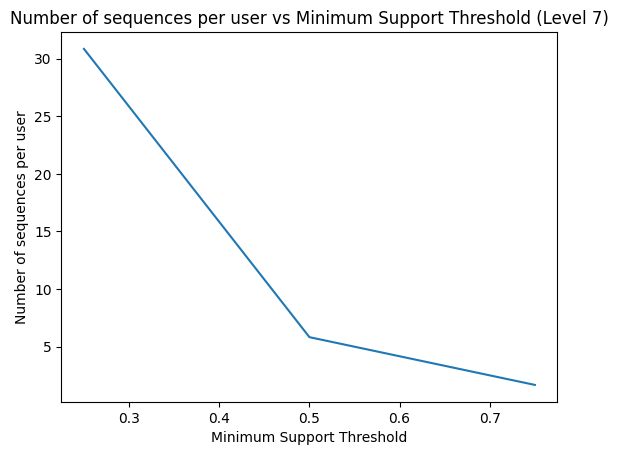

In [16]:
plt.plot(res_7[0], res_7[1])
plt.xlabel('Minimum Support Threshold')
plt.ylabel('Number of sequences per user')
plt.title('Number of sequences per user vs Minimum Support Threshold (Level 7)')
plt.show()

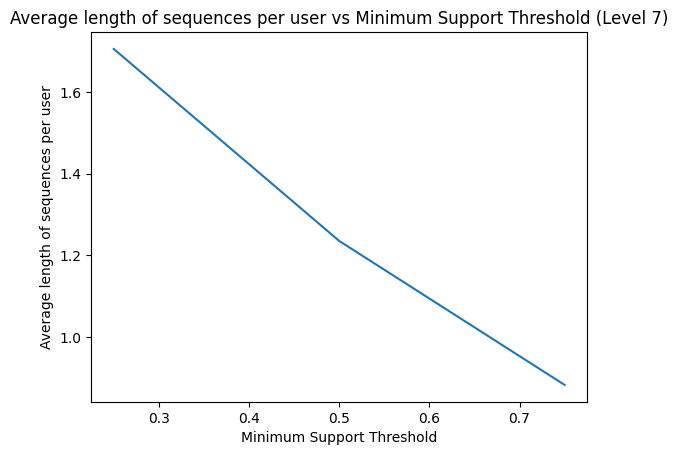

In [17]:
plt.plot(res_7[0], res_7[2])
plt.xlabel('Minimum Support Threshold')
plt.ylabel('Average length of sequences per user')
plt.title('Average length of sequences per user vs Minimum Support Threshold (Level 7)')
plt.show()

## Experiment 3 (Assignment test)

Test on 7 categories
Test on the four order of assignments (random, preference, demanding, preference + demanding, demanding + preference)
Each go for 1000 times


In [18]:
import random

random.seed(42)

In [19]:
## Defining global variables
providers_preferences_7 = decode_probabilistic_patterns("0.5_7_probabilistic_patterns.csv")
## Defining the category_list for different levels
category_list_7 = ['E', 'Sh', 'Edu', 'Out', 'Ent', 'F', 'O']

In [20]:
def initialise_all_stuff(providers_no, microcells_no, number_of_category):
    providers_probabilistic_patterns = []
    providers_availability = []
    availability_file='availability.txt'
    
    microcell_preference_dict = {}
    microcell_location_request_dict = {}
    request_sum = 0

    # Load availability from file
    with open(availability_file, 'r') as f:
        lines = f.readlines()
        providers_availability = [int(line.strip()) for line in lines]
       
    # Trim or pad the availability list to match providers_no
    if len(providers_availability) < providers_no:
        raise ValueError("Not enough availability values in the file.")
    providers_availability = providers_availability[:providers_no]

    

    providers_preferences = providers_preferences_7
    category_list = category_list_7
        
    for i in range(providers_no):
        providers_probabilistic_patterns.append(providers_preferences[random.randint(0, len(providers_preferences)-1)])
        
#     providers_info = sorted(zip(providers_probabilistic_patterns, providers_availability), key=lambda pair: pair[1], reverse=True)
        
    for j in range(microcells_no):
        microcell_id = j
        microcell_category = category_list[random.randint(0, len(category_list)-1)]
        microcell_request = random.randint(1000, 2000)
        request_sum += microcell_request
        
        microcell_location_request_dict[microcell_id] = {'request': microcell_request, 'category': microcell_category}
        
        if microcell_category in microcell_preference_dict:
            microcell_preference_dict[microcell_category].append(microcell_id)
        else:
            microcell_preference_dict[microcell_category] = [microcell_id]
        
    return providers_probabilistic_patterns, providers_availability, microcell_preference_dict, microcell_location_request_dict, request_sum

## simulated-annealing

In [21]:
# Helper 1: Generate initial solution using microcell_led heuristic
def generate_initial_microcell_led(providers_availability, microcell_location_request_dict, providers_probabilistic_patterns, respondents):
    allocation = []  # List of tuples: (provider_id, loc_key, supply, preference_rank)
    for loc_key, loc_data in sorted(microcell_location_request_dict.items(), key=lambda x: x[1]['request'], reverse=True):
        request = loc_data['request']
        loc_category = loc_data['category']

        while request > 0:
            best_provider = None
            best_pref_index = float('inf')
            for j in respondents:
                if providers_availability[j] <= 0:
                    continue
                pattern = sorted(providers_probabilistic_patterns[j][0].items(), key=lambda item: item[1], reverse=True)
                for k, (cat, _) in enumerate(pattern):
                    if cat == loc_category:
                        if k < best_pref_index:
                            best_provider = j
                            best_pref_index = k
                        break

            if best_provider is None:
                break

            available = providers_availability[best_provider]
            supply = min(request, available)
            providers_availability[best_provider] -= supply
            request -= supply
            microcell_location_request_dict[loc_key]['request'] = request

            allocation.append((best_provider, loc_key, supply, best_pref_index))

    return allocation


# Helper 2: Generate neighbor by swapping two provider assignments
def generate_neighbor(solution):
    neighbor = solution[:]
    if len(neighbor) < 2:
        return neighbor
    i, j = random.sample(range(len(neighbor)), 2)
    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor


# Helper 3: Score = fulfillment - cost (weighted)
def evaluate_solution(solution, w1=1.0, w2=0.05):
    fulfillment = sum(s[2] for s in solution)
    cost = sum(((s[2] / 100) * (s[3] + 1)) for s in solution)
    return (w1 * fulfillment) - (w2 * cost)


# Helper 4: Extract fulfillment and cost from solution
def extract_metrics(solution):
    fulfillment = sum(s[2] for s in solution)
    cost = sum(((s[2] / 100) * (s[3] + 1)) for s in solution)
    return fulfillment, cost


In [22]:
def experiment(providers_no, microcells_no, mode, number_of_category, iterations):
    energy_usage_record_list = []
    fulfillment_ratio_record_list = []
    cost_record_list = []
    time_record_list = []

    for _ in range(iterations):
        start_time = time.time()
        providers_probabilistic_patterns, providers_availability, microcell_preference_dict, microcell_location_request_dict, request_sum = initialise_all_stuff(
            providers_no, microcells_no, number_of_category)
        providers_info = sorted(zip(providers_probabilistic_patterns, providers_availability), key=lambda pair: pair[1], reverse=True)

        total_available_energy = np.sum(providers_availability)
        fulfillment_energy = 0
        cost = 0
        supplied_providers = 0

        # -------- Special case modes: simulated_annealing --------
        if mode == 'simulated_annealing':
            current_solution = generate_initial_microcell_led(providers_availability.copy(),
                                                              microcell_location_request_dict.copy(),
                                                              providers_probabilistic_patterns,
                                                              list(range(providers_no)))
            best_solution = current_solution
            best_score = evaluate_solution(best_solution)

            T = 1.0
            T_min = 0.01
            alpha = 0.9
            iteration_sa = 100

            while T > T_min:
                for _ in range(iteration_sa):
                    neighbor_solution = generate_neighbor(current_solution)
                    neighbor_score = evaluate_solution(neighbor_solution)
                    delta = neighbor_score - best_score
                    if delta > 0 or np.exp(delta / T) > random.random():
                        current_solution = neighbor_solution
                        if neighbor_score > best_score:
                            best_solution = neighbor_solution
                            best_score = neighbor_score
                T *= alpha

            fulfillment_energy, cost = extract_metrics(best_solution)
            fulfillment_ratio = fulfillment_energy / request_sum
            energy_usage_record_list.append(fulfillment_energy / total_available_energy)
            fulfillment_ratio_record_list.append(fulfillment_ratio)
            cost_record_list.append(cost)
            time_record_list.append(time.time() - start_time)
            continue

        # -------- All other per-provider modes --------
        for j in range(providers_no):
            supplying = False
            provider_pattern = sorted(providers_probabilistic_patterns[j][0].items(), key=lambda item: item[1], reverse=True)
            provider_availability = providers_availability[j]
            loc_key = None

            if  mode == 'Preference_only':
                top_cat = provider_pattern[0][0]
                if top_cat in microcell_preference_dict:
                    loc_key = random.choice(microcell_preference_dict[top_cat])

            elif mode == 'Energy_only':
                loc_key = sorted(microcell_location_request_dict.items(), key=lambda item: item[1]['request'], reverse=True)[0][0]

            elif mode == 'huerstic_based':
                demand_sorted = sorted(microcell_location_request_dict.items(), key=lambda item: item[1]['request'], reverse=True)
                prefs = [cat for cat, _ in provider_pattern]
                for loc_id, loc in demand_sorted:
                    if loc['category'] in prefs and loc['request'] > 0:
                        loc_key = loc_id
                        break
                if loc_key is None:
                    loc_key = demand_sorted[0][0]

            elif mode == 'score_based':
                w1, w2, w3 = 1.0, 1.0, 1.0
                best_score = -float('inf')
                for loc_id, loc in microcell_location_request_dict.items():
                    if loc['request'] <= 0:
                        continue
                    for rank, (cat, _) in enumerate(provider_pattern):
                        if cat == loc['category']:
                            score = w1 * loc['request'] - w2 * (rank + 1) - w3 * (provider_availability / 100)
                            if score > best_score:
                                best_score = score
                                loc_key = loc_id
                            break

      
            if loc_key is not None:
                request = microcell_location_request_dict[loc_key]['request']
                if request > 0 and providers_availability[j] > 0:
                    supply = min(request, providers_availability[j])
                    fulfillment_energy += supply
                    providers_availability[j] -= supply
                    microcell_location_request_dict[loc_key]['request'] -= supply
                    supplied_providers += 1
            
                    # Optional: compute cost based on preference
                    preference_index = len(provider_pattern) + 1
                    for k, (cat, _) in enumerate(provider_pattern):
                        if cat == microcell_location_request_dict[loc_key]['category']:
                            preference_index = k + 1
                            break
                    cost += ((supply / 100) * preference_index)

        
        energy_usage_record_list.append(fulfillment_energy / total_available_energy)
        fulfillment_ratio_record_list.append(fulfillment_energy / request_sum)
        if supplied_providers > 0:
            cost_record_list.append(cost)
        time_record_list.append(time.time() - start_time)

    return np.mean(energy_usage_record_list), np.mean(fulfillment_ratio_record_list), np.mean(cost_record_list), np.mean(time_record_list)


In [23]:
def test_all_combinations(number_of_iterations):
    levels = [7]
    no_of_variants = [5, 10, 15, 20, 25, 30]

    modes = [
    'Preference_only',               # providers assign to their top preferred category
    'Energy_Only',                # providers assign to the most demanding microcell
    'huerstic_based',     # demand filtered, then preference used to assign
    'score_based',                     # Scoring function: demand - pref_rank - reward
    'simulated_annealing'
    ]
    
    results = []
    
    result_dict_fixed_providers = {}
    result_dict_fixed_microcells = {}
    
    for level in levels:    
        for variant_number in no_of_variants:
            for mode in modes:
                start_time = time.time()
                
                EU_providers, FR_providers, C_providers, T_providers = experiment(15, variant_number, mode, level, number_of_iterations)

                EU_tag = '{}_{}_{}_{}_EU'.format(level, 15, variant_number, mode)
                FR_tag = '{}_{}_{}_{}_FR'.format(level, 15, variant_number, mode)
                C_tag = '{}_{}_{}_{}_C'.format(level, 15, variant_number, mode)
                T_tag = '{}_{}_{}_{}_T'.format(level, 15, variant_number, mode)
                result_dict_fixed_providers[EU_tag] = EU_providers
                result_dict_fixed_providers[FR_tag] = FR_providers
                result_dict_fixed_providers[C_tag] = C_providers
                result_dict_fixed_providers[T_tag] = T_providers

                EU_microcells, FR_microcells, C_microcells, T_microcells = experiment(variant_number, 15, mode, level, number_of_iterations)

                EU_tag = '{}_{}_{}_{}_EU'.format(level, variant_number, 15, mode)
                FR_tag = '{}_{}_{}_{}_FR'.format(level, variant_number, 15, mode)
                C_tag = '{}_{}_{}_{}_C'.format(level, variant_number, 15, mode)
                T_tag = '{}_{}_{}_{}_T'.format(level, variant_number, 15, mode)
                result_dict_fixed_microcells[EU_tag] = EU_microcells
                result_dict_fixed_microcells[FR_tag] = FR_microcells
                result_dict_fixed_microcells[C_tag] = C_microcells
                result_dict_fixed_microcells[T_tag] = T_microcells
                
                print("Finished 1 setup")
                print("Time taken: {:.2f}".format((time.time()-start_time)/60))

    return result_dict_fixed_providers, result_dict_fixed_microcells

In [24]:
result_dict_fixed_providers, result_dict_fixed_microcells = test_all_combinations(1000)

Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 setup
Time taken: 0.00
Finished 1 set

/Users/aabusafia/pymoo-env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aabusafia/pymoo-env/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
result_dict_fixed_microcells

{'7_5_15_Preference_only_EU': 0.9190047644256221,
 '7_5_15_Preference_only_FR': 0.07690603818721481,
 '7_5_15_Preference_only_C': 17.36,
 '7_5_15_Preference_only_T': 0.00026702880859375,
 '7_5_15_Energy_Only_EU': 0.0,
 '7_5_15_Energy_Only_FR': 0.0,
 '7_5_15_Energy_Only_C': nan,
 '7_5_15_Energy_Only_T': 0.0001399517059326172,
 '7_5_15_huerstic_based_EU': 1.0,
 '7_5_15_huerstic_based_FR': 0.07632631621479656,
 '7_5_15_huerstic_based_C': 28.98,
 '7_5_15_huerstic_based_T': 0.00011801719665527344,
 '7_5_15_score_based_EU': 1.0,
 '7_5_15_score_based_FR': 0.09380276094944881,
 '7_5_15_score_based_C': 38.879999999999995,
 '7_5_15_score_based_T': 0.00012683868408203125,
 '7_5_15_simulated_annealing_EU': 0.7924827951296982,
 '7_5_15_simulated_annealing_FR': 0.06436771724642043,
 '7_5_15_simulated_annealing_C': 27.120000000000005,
 '7_5_15_simulated_annealing_T': 0.016028165817260742,
 '7_10_15_Preference_only_EU': 1.0,
 '7_10_15_Preference_only_FR': 0.1772234678624813,
 '7_10_15_Preference_only_

In [26]:
result_dict_fixed_providers

{'7_15_5_Preference_only_EU': 0.0,
 '7_15_5_Preference_only_FR': 0.0,
 '7_15_5_Preference_only_C': nan,
 '7_15_5_Preference_only_T': 0.0022242069244384766,
 '7_15_5_Energy_Only_EU': 0.0,
 '7_15_5_Energy_Only_FR': 0.0,
 '7_15_5_Energy_Only_C': nan,
 '7_15_5_Energy_Only_T': 0.0003380775451660156,
 '7_15_5_huerstic_based_EU': 0.9836676726433516,
 '7_15_5_huerstic_based_FR': 0.7052310042000763,
 '7_15_5_huerstic_based_C': 132.42000000000002,
 '7_15_5_huerstic_based_T': 0.00015401840209960938,
 '7_15_5_score_based_EU': 0.8080951535593822,
 '7_15_5_score_based_FR': 0.5708552796588914,
 '7_15_5_score_based_C': 102.76,
 '7_15_5_score_based_T': 0.0001437664031982422,
 '7_15_5_simulated_annealing_EU': 0.35966625244097283,
 '7_15_5_simulated_annealing_FR': 0.2845505617977528,
 '7_15_5_simulated_annealing_C': 36.63,
 '7_15_5_simulated_annealing_T': 0.023993968963623047,
 '7_15_10_Preference_only_EU': 0.4592579442570566,
 '7_15_10_Preference_only_FR': 0.2055621771950735,
 '7_15_10_Preference_only_C

In [27]:
providers_probabilistic_patterns, providers_availability, microcell_preference_dict, microcell_location_request_dict, request_sum = initialise_all_stuff(5, 10, 7)

In [28]:
providers_availability

[392, 367, 275, 470, 385]

In [29]:
microcell_location_request_dict # Total demand 13879

{0: {'request': 1924, 'category': 'Edu'},
 1: {'request': 1079, 'category': 'O'},
 2: {'request': 1034, 'category': 'O'},
 3: {'request': 1541, 'category': 'F'},
 4: {'request': 1406, 'category': 'Ent'},
 5: {'request': 1199, 'category': 'Edu'},
 6: {'request': 1284, 'category': 'E'},
 7: {'request': 1441, 'category': 'Ent'},
 8: {'request': 1759, 'category': 'F'},
 9: {'request': 1146, 'category': 'Out'}}

In [30]:
providers_probabilistic_patterns

[[{'E': 0.57, 'O': 0.43}],
 [{'Sh': 0.52, 'E': 0.28, 'O': 0.2}, {'E': 1.0}],
 [{'Out': 1.0}],
 [{'O': 0.34, 'E': 0.48, 'Sh': 0.18},
  {'E': 0.47, 'O': 0.31, 'Sh': 0.22},
  {'O': 0.34, 'E': 0.43, 'Sh': 0.23},
  {'O': 0.33, 'E': 0.67}],
 [{'O': 0.51, 'E': 0.49}, {'O': 1.0}]]

In [31]:
provider_probabilistic_pattern_timestep_1 = [sorted(providers_probabilistic_patterns[i][0].items(), key=lambda item: item[1], reverse=True) for i in range(len(providers_probabilistic_patterns))]
provider_probabilistic_pattern_timestep_1

[[('E', 0.57), ('O', 0.43)],
 [('Sh', 0.52), ('E', 0.28), ('O', 0.2)],
 [('Out', 1.0)],
 [('E', 0.48), ('O', 0.34), ('Sh', 0.18)],
 [('O', 0.51), ('E', 0.49)]]

In [32]:
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.factory import get_sampling, get_crossover, get_mutation
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import copy
import time


class ServiceAllocationProblem(ElementwiseProblem):

    def __init__(self, providers_probabilistic_patterns, providers_availability, microcell_location_request_dict, providers_no, microcell_no):
        super().__init__(n_var=providers_no,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([0] * providers_no),
                         xu=np.array([microcell_no - 1] * providers_no))
        self.providers_availability = providers_availability
        self.total_available_energy = np.sum(providers_availability)
        self.providers_probabilistic_patterns = providers_probabilistic_patterns
        self.microcell_location_request_dict = microcell_location_request_dict
        
        self.total_demand = 0
        for i in range(len(self.microcell_location_request_dict)):
            self.total_demand += self.microcell_location_request_dict[i]['request']

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 0
        f2 = 0
        total_demand = 0
        total_fulfilled_energy = 0
        
        microcell_loc_req_dict = copy.deepcopy(self.microcell_location_request_dict)
        
        # Maxmize the energy fulfillment across the microcell
        for i in range(len(x)):
            request = microcell_loc_req_dict[x[i]]['request']
            loc_category = microcell_loc_req_dict[x[i]]['category']
            
            provider_availability = self.providers_availability[i]
            
            if request > provider_availability:
                total_fulfilled_energy += provider_availability
                microcell_loc_req_dict[x[i]]['request'] = (request - provider_availability)
            else:
                total_fulfilled_energy += request
                microcell_loc_req_dict[x[i]]['request'] = 0
            
            provider_preferences = self.providers_probabilistic_patterns[i]
            preference_index = len(provider_preferences)+1
            for k in range(len(provider_preferences)):
                if loc_category == provider_preferences[k][0]:
                    preference_index = k+1
                
                f2 += ((provider_availability / 100) * preference_index)
        
        f1 = (total_fulfilled_energy / self.total_demand) * -1

        out["F"] = [f1, f2]


start_time = time.time()
problem = ServiceAllocationProblem(provider_probabilistic_pattern_timestep_1, providers_availability, microcell_location_request_dict, 5, 10)

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=40,
    sampling=get_sampling("int_random"),
    crossover=get_crossover("int_sbx", prob=0.5, eta=15),
    mutation=get_mutation("int_pm", eta=20),
    eliminate_duplicates=True
)

res = minimize(problem,
               algorithm,
               verbose=True,
               seed=1,
               save_history=True)

print(time.time() - start_time)


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.config import Config
Config.show_compile_hint = False

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      40 |       1 |            - |            -
    2 |      80 |       1 |  1.26500E+01 |        ideal
    3 |     120 |       1 |  6.420000000 |        ideal
    4 |     160 |       1 |  0.00000E+00 |            f
    5 |     200 |       2 |  0.00000E+00 |            f
    6 |     240 |       1 |  1.10100E+01 |        ideal
    7 |     280 |       2 |  0.00000E+00 |            f
    8 |     320 |       2 |  0.00000E+00 |            f
    9 |     360 |       2 |  0.00000E+00 |            f
   10 |     400 |       2 |  0.00000E+00 |            f
   11 |     440 |       2 |  0.00000E+00 |            f
   12 |     480 |       2 |  0.00000E+00 |            f
   13 |     520 |       2 |  0.00000E+00 |            f
   14 |     560 

In [33]:
def experiment_GA(providers_no, microcells_no, number_of_category, iterations):
    energy_usage_record_list = []
    fulfillment_ratio_record_list = []
    cost_record_list = []
    time_record_list = []
    
    for i in range(iterations):
        start_time = time.time()
                
        providers_probabilistic_patterns, providers_availability, microcell_preference_dict, microcell_location_request_dict, request_sum = initialise_all_stuff(providers_no, microcells_no, number_of_category)
        provider_probabilistic_pattern_timestep_1 = [sorted(providers_probabilistic_patterns[i][0].items(), key=lambda item: item[1], reverse=True) for i in range(len(providers_probabilistic_patterns))]

        problem = ServiceAllocationProblem(provider_probabilistic_pattern_timestep_1, providers_availability, microcell_location_request_dict, providers_no, microcells_no)

        algorithm = NSGA2(
                pop_size=40,
                n_offsprings=40,
                sampling=get_sampling("int_random"),
                crossover=get_crossover("int_sbx", prob=0.5, eta=15),
                mutation=get_mutation("int_pm", eta=20),
                eliminate_duplicates=True
                )
        res = minimize(problem,
                       algorithm,
                       save_history=True)
        

        EU, FR, C = evaluate_EU_FR_C_GA(res, microcell_location_request_dict, providers_availability)
        energy_usage_record_list.append(EU)
        fulfillment_ratio_record_list.append(FR)
        cost_record_list.append(C)
        time_record_list.append(time.time()-start_time)
        
    return np.mean(energy_usage_record_list), np.mean(fulfillment_ratio_record_list), np.mean(cost_record_list), np.mean(time_record_list)

In [34]:
def evaluate_EU_FR_C_GA(res, microcell_location_request_dict, providers_availability):
    # Pick the best candidate in terms of FR and C
    X = res.X # chromosomes
    F = res.F # fitness score
    sorted_list = [(x, f) for f, x in sorted(zip(F.tolist(), X.tolist()), key=lambda pair: pair[0])]
    
    best_chromosome_fitness = sorted_list[0]
#     print(best_chromosome_fitness)
    FR, C = best_chromosome_fitness[1][0] * -1, best_chromosome_fitness[1][1]
    
    # Evaluate the EU
    total_fulfilled_energy = 0
    total_available_energy = np.sum(providers_availability)
    microcell_loc_req_dict = copy.deepcopy(microcell_location_request_dict)

    # Maxmize the energy fulfillment across the microcell
    x = best_chromosome_fitness[0]
    for i in range(len(x)):
#         print(x[i])
        request = microcell_loc_req_dict[x[i]]['request']
        provider_availability = providers_availability[i]

        if request > provider_availability:
            total_fulfilled_energy += provider_availability
            microcell_loc_req_dict[x[i]]['request'] = (request - provider_availability)
        else:
            total_fulfilled_energy += request
            microcell_loc_req_dict[x[i]]['request'] = 0
            
    EU = total_fulfilled_energy / total_available_energy
    
    return EU, FR, C

In [35]:
def test_all_combinations_genetic(number_of_iterations):
    levels = [7]
    no_of_variants = [5, 10, 15, 20, 25, 30]
    
    result_dict_fixed_providers_GA = {}
    result_dict_fixed_microcells_GA = {}
    
    for level in levels:    
        for variant_number in no_of_variants:
            # Fixed the number of providers
            
            start_time = time.time()
            
            EU_providers, FR_providers, C_providers, T_providers = experiment_GA(15, variant_number, level, number_of_iterations)
            EU_tag = '{}_{}_{}_{}_EU'.format(level, 15, variant_number, 'GA')
            FR_tag = '{}_{}_{}_{}_FR'.format(level, 15, variant_number, 'GA')
            C_tag = '{}_{}_{}_{}_C'.format(level, 15, variant_number, 'GA')
            T_tag = '{}_{}_{}_{}_T'.format(level, 15, variant_number, 'GA')
            result_dict_fixed_providers_GA[EU_tag] = EU_providers
            result_dict_fixed_providers_GA[FR_tag] = FR_providers
            result_dict_fixed_providers_GA[C_tag] = C_providers
            result_dict_fixed_providers_GA[T_tag] = T_providers
            
            EU_microcells, FR_microcells, C_microcells, T_microcells = experiment_GA(variant_number, 15, level, number_of_iterations)

            EU_tag = '{}_{}_{}_{}_EU'.format(level, variant_number, 15, 'GA')
            FR_tag = '{}_{}_{}_{}_FR'.format(level, variant_number, 15, 'GA')
            C_tag = '{}_{}_{}_{}_C'.format(level, variant_number, 15, 'GA')
            T_tag = '{}_{}_{}_{}_T'.format(level, variant_number, 15, 'GA')
            result_dict_fixed_microcells_GA[EU_tag] = EU_microcells
            result_dict_fixed_microcells_GA[FR_tag] = FR_microcells
            result_dict_fixed_microcells_GA[C_tag] = C_microcells
            result_dict_fixed_microcells_GA[T_tag] = T_microcells
            
            print("Finished 1 setup")
            print("Time taken: {:.2f}".format((time.time()-start_time)/60))

    return result_dict_fixed_providers_GA, result_dict_fixed_microcells_GA

## We test GA here

In [ ]:
result_dict_fixed_providers_GA, result_dict_fixed_microcells_GA = test_all_combinations_genetic(1000)

In [ ]:
result_dict_fixed_microcells_GA

In [ ]:
import os

# Play macOS system voice
os.system("say 'Code execution is complete'")


## Experiment on responsive rate

Start with GA

In [ ]:
def experiment_GA_response_rate(providers_no, microcells_no, number_of_category, iterations, number_of_respondents):
    algorithm = NSGA2(
                pop_size=40,
                n_offsprings=40,
                sampling=get_sampling("int_random"),
                crossover=get_crossover("int_sbx", prob=0.5, eta=15),
                mutation=get_mutation("int_pm", eta=20),
                eliminate_duplicates=True
                )
    
    energy_usage_record_list = []
    fulfillment_ratio_record_list = []
    cost_record_list = []
    time_record_list = []
    
    for i in range(iterations):
        start_time = time.time()
        
        providers_probabilistic_patterns, providers_availability, microcell_preference_dict, microcell_location_request_dict, request_sum = initialise_all_stuff(providers_no, microcells_no, number_of_category)
        provider_probabilistic_pattern_timestep_1 = [sorted(providers_probabilistic_patterns[i][0].items(), key=lambda item: item[1], reverse=True) for i in range(len(providers_probabilistic_patterns))]
            
        problem = ServiceAllocationProblem(provider_probabilistic_pattern_timestep_1, providers_availability, microcell_location_request_dict, providers_no, microcells_no)

        res = minimize(problem,
                       algorithm,
                       seed=1,
                       save_history=True)

        EU, FR, C = evaluate_EU_FR_C_GA_response_rate(res, provider_probabilistic_pattern_timestep_1, microcell_location_request_dict, providers_availability, number_of_respondents, providers_no)
        energy_usage_record_list.append(EU)
        fulfillment_ratio_record_list.append(FR)
        cost_record_list.append(C)
        time_record_list.append(time.time() - start_time)
        
    return np.mean(energy_usage_record_list), np.mean(fulfillment_ratio_record_list), np.mean(cost_record_list), np.mean(time_record_list)

In [ ]:
def evaluate_EU_FR_C_GA_response_rate(res, providers_probabilistic_patterns, microcell_location_request_dict, providers_availability, number_of_respondents, providers_no):
    # Pick the best candidate in terms of FR and C
    X = res.X # chromosomes
    F = res.F # fitness score
    sorted_list = [(x, f) for f, x in sorted(zip(F.tolist(), X.tolist()), key=lambda pair: pair[0])]
    
    best_chromosome_fitness = sorted_list[0]
#     print(best_chromosome_fitness)
#     FR, C = best_chromosome_fitness[1][0] * -1, best_chromosome_fitness[1][1]
    
    # Initialise variables
    total_fulfilled_energy = 0
    total_available_energy = np.sum(providers_availability)
    total_demand = 0
    microcell_loc_req_dict = copy.deepcopy(microcell_location_request_dict)
    
    for i in range(len(microcell_location_request_dict)):
            total_demand += microcell_location_request_dict[i]['request']
            
    FR = 0
    C = 0
    respondents = random.sample(range(0, providers_no), number_of_respondents)

    # Maxmize the energy fulfillment across the microcell
    x = best_chromosome_fitness[0]
    for i in range(len(respondents)):
#         print(x[i])
        request = microcell_loc_req_dict[x[respondents[i]]]['request']
        loc_category = microcell_loc_req_dict[x[respondents[i]]]['category']
        provider_availability = providers_availability[respondents[i]]

        if request > provider_availability:
            total_fulfilled_energy += provider_availability
            microcell_loc_req_dict[x[respondents[i]]]['request'] = (request - provider_availability)
        else:
            total_fulfilled_energy += request
            microcell_loc_req_dict[x[respondents[i]]]['request'] = 0
            
        provider_preferences = providers_probabilistic_patterns[respondents[i]]
        preference_index = len(provider_preferences)+1
        for k in range(len(provider_preferences)):
            if loc_category == provider_preferences[k][0]:
                preference_index = k+1

            C += ((provider_availability / 100) * preference_index)
            
    EU = total_fulfilled_energy / total_available_energy
    FR = total_fulfilled_energy / total_demand
    
    return EU, FR, C

In [ ]:
def test_all_combinations_genetic_response_rate(number_of_iterations):
    number_of_respondents_options = [3, 6, 9, 12, 15]   
    
    result_dict_GA_response_rate = {}
    
    level = 7
    variant_number = 15 # microcell_number
    
    for number_of_respondents in number_of_respondents_options: 
            # Fixed the number of providers
            start_time = time.time()
            
            EU, FR, C, T = experiment_GA_response_rate(15, variant_number, level, number_of_iterations, number_of_respondents) # providers_no, microcells_no
            EU_tag = '{}_{}_{}_{}_{}_EU'.format(level, 15, variant_number, number_of_respondents, 'GA')
            FR_tag = '{}_{}_{}_{}_{}_FR'.format(level, 15, variant_number, number_of_respondents, 'GA')
            C_tag = '{}_{}_{}_{}_{}_C'.format(level, 15, variant_number, number_of_respondents, 'GA')
            T_tag = '{}_{}_{}_{}_{}_T'.format(level, 15, variant_number, number_of_respondents, 'GA')
            result_dict_GA_response_rate[EU_tag] = EU
            result_dict_GA_response_rate[FR_tag] = FR
            result_dict_GA_response_rate[C_tag] = C
            result_dict_GA_response_rate[T_tag] = T
            print("Finished setup",number_of_respondents)
            print("Time taken: {:.2f}".format((time.time()-start_time)/60))

    return result_dict_GA_response_rate

In [ ]:
#result_dict_GA_response_rate = test_all_combinations_genetic_response_rate(1000)
result_dict_GA_response_rate = test_all_combinations_genetic_response_rate(1000)

In [ ]:
result_dict_GA_response_rate

Now with all other methods

In [36]:
def experiment2(providers_no, microcells_no, mode, number_of_category, iterations,active_providers_count=None):
    energy_usage_record_list = []
    fulfillment_ratio_record_list = []
    cost_record_list = []
    time_record_list = []

    for _ in range(iterations):

        if active_providers_count is None:
            active_provider_indices = list(range(providers_no))
        else:
            active_provider_indices = random.sample(range(providers_no), active_providers_count)
        start_time = time.time()
        providers_probabilistic_patterns, providers_availability, microcell_preference_dict, microcell_location_request_dict, request_sum = initialise_all_stuff(
            providers_no, microcells_no, number_of_category)
        providers_info = sorted(zip(providers_probabilistic_patterns, providers_availability), key=lambda pair: pair[1], reverse=True)

        total_available_energy = np.sum(providers_availability)
        fulfillment_energy = 0
        cost = 0
        supplied_providers = 0

        # -------- simulated_annealing --------
        if mode == 'simulated_annealing':
            current_solution = generate_initial_microcell_led(
            providers_availability.copy(),
            microcell_location_request_dict.copy(),
            providers_probabilistic_patterns,
            active_provider_indices )

            best_solution = current_solution
            best_score = evaluate_solution(best_solution)

            T = 1.0
            T_min = 0.01
            alpha = 0.9
            iteration_sa = 100

            while T > T_min:
                for _ in range(iteration_sa):
                    neighbor_solution = generate_neighbor(current_solution)
                    neighbor_score = evaluate_solution(neighbor_solution)
                    delta = neighbor_score - best_score
                    if delta > 0 or np.exp(delta / T) > random.random():
                        current_solution = neighbor_solution
                        if neighbor_score > best_score:
                            best_solution = neighbor_solution
                            best_score = neighbor_score
                T *= alpha

            fulfillment_energy, cost = extract_metrics(best_solution)
            fulfillment_ratio = fulfillment_energy / request_sum
            energy_usage_record_list.append(fulfillment_energy / total_available_energy)
            fulfillment_ratio_record_list.append(fulfillment_ratio)
            cost_record_list.append(cost)
            time_record_list.append(time.time() - start_time)
            continue

        # -------- All other per-provider modes --------
        for j in active_provider_indices:
            supplying = False
            provider_pattern = sorted(providers_probabilistic_patterns[j][0].items(), key=lambda item: item[1], reverse=True)
            provider_availability = providers_availability[j]
            loc_key = None

            if mode == 'Preference_only':
                top_cat = provider_pattern[0][0]
                if top_cat in microcell_preference_dict:
                    loc_key = random.choice(microcell_preference_dict[top_cat])

            elif mode == 'Energy_only':
                loc_key = sorted(microcell_location_request_dict.items(), key=lambda item: item[1]['request'], reverse=True)[0][0]

            elif mode == 'huerstic_based':
                demand_sorted = sorted(microcell_location_request_dict.items(), key=lambda item: item[1]['request'], reverse=True)
                prefs = [cat for cat, _ in provider_pattern]
                for loc_id, loc in demand_sorted:
                    if loc['category'] in prefs and loc['request'] > 0:
                        loc_key = loc_id
                        break
                if loc_key is None:
                    loc_key = demand_sorted[0][0]

            elif mode == 'score_based':
                w1, w2, w3 = 1.0, 1.0, 1.0
                best_score = -float('inf')
                for loc_id, loc in microcell_location_request_dict.items():
                    if loc['request'] <= 0:
                        continue
                    for rank, (cat, _) in enumerate(provider_pattern):
                        if cat == loc['category']:
                            score = w1 * loc['request'] - w2 * (rank + 1) - w3 * (provider_availability / 100)
                            if score > best_score:
                                best_score = score
                                loc_key = loc_id
                            break

            if loc_key is not None:
                request = microcell_location_request_dict[loc_key]['request']
                if request > 0 and providers_availability[j] > 0:
                    supply = min(request, providers_availability[j])
                    fulfillment_energy += supply
                    providers_availability[j] -= supply
                    microcell_location_request_dict[loc_key]['request'] -= supply
                    supplied_providers += 1
        
                    # Optional: compute cost based on preference
                    preference_index = len(provider_pattern) + 1
                    for k, (cat, _) in enumerate(provider_pattern):
                        if cat == microcell_location_request_dict[loc_key]['category']:
                            preference_index = k + 1
                            break
                    cost += ((supply / 100) * preference_index)

        energy_usage_record_list.append(fulfillment_energy / total_available_energy)
        fulfillment_ratio_record_list.append(fulfillment_energy / request_sum)
        if supplied_providers > 0:
            cost_record_list.append(cost)
        time_record_list.append(time.time() - start_time)

    return np.mean(energy_usage_record_list), np.mean(fulfillment_ratio_record_list), np.mean(cost_record_list), np.mean(time_record_list)


In [37]:
def test_all_combinations2(number_of_iterations):
    provider_group_sizes = [3, 6, 9, 12,15]

    levels = [7]
    no_of_variants = [15]  # <-- keep it a list so it's iterable

    modes = [
    'Preference_only',               # providers assign to their top preferred category
    'Energy_only',                # providers assign to the most demanding microcell
    'huerstic_based',     # demand filtered, then preference used to assign
    'score_based',                     # Scoring function: demand - pref_rank - reward
    'simulated_annealing'
    ]
    
    results = []
    
    result_dict_fixed_providers = {}
    result_dict_fixed_microcells = {}
    
    for level in levels:    
        for variant_number in no_of_variants:
            for mode in modes:
              
                
                EU_providers, FR_providers, C_providers, T_providers = experiment2(15, variant_number, mode, level, number_of_iterations)

                EU_tag = '{}_{}_{}_{}_EU'.format(level, 15, variant_number, mode)
                FR_tag = '{}_{}_{}_{}_FR'.format(level, 15, variant_number, mode)
                C_tag = '{}_{}_{}_{}_C'.format(level, 15, variant_number, mode)
                T_tag = '{}_{}_{}_{}_T'.format(level, 15, variant_number, mode)
                result_dict_fixed_providers[EU_tag] = EU_providers
                result_dict_fixed_providers[FR_tag] = FR_providers
                result_dict_fixed_providers[C_tag] = C_providers
                result_dict_fixed_providers[T_tag] = T_providers

                for group_size in provider_group_sizes:
                    start_time = time.time()
                    EU, FR, C, T = experiment2(
                        variant_number, 15, mode, level, number_of_iterations,
                        active_providers_count=group_size
                    )
                
                    tag_prefix = f"{level}_{variant_number}_15_{mode}_N{group_size}"
                    result_dict_fixed_microcells[f"{tag_prefix}_EU"] = EU
                    result_dict_fixed_microcells[f"{tag_prefix}_FR"] = FR
                    result_dict_fixed_microcells[f"{tag_prefix}_C"] = C
                    result_dict_fixed_microcells[f"{tag_prefix}_T"] = T
                
                    print(f"Finished mode={mode}, N={group_size}")
                print("Time taken: {:.2f}".format((time.time()-start_time)/60))

    return result_dict_fixed_providers, result_dict_fixed_microcells

In [38]:
result_dict_response_rate2 = test_all_combinations2(1000)

Finished mode=Preference_only, N=3
Finished mode=Preference_only, N=6
Finished mode=Preference_only, N=9
Finished mode=Preference_only, N=12
Finished mode=Preference_only, N=15
Time taken: 0.00
Finished mode=Energy_only, N=3
Finished mode=Energy_only, N=6
Finished mode=Energy_only, N=9
Finished mode=Energy_only, N=12
Finished mode=Energy_only, N=15
Time taken: 0.00
Finished mode=huerstic_based, N=3
Finished mode=huerstic_based, N=6
Finished mode=huerstic_based, N=9
Finished mode=huerstic_based, N=12
Finished mode=huerstic_based, N=15
Time taken: 0.00
Finished mode=score_based, N=3
Finished mode=score_based, N=6
Finished mode=score_based, N=9
Finished mode=score_based, N=12
Finished mode=score_based, N=15
Time taken: 0.00
Finished mode=simulated_annealing, N=3
Finished mode=simulated_annealing, N=6
Finished mode=simulated_annealing, N=9
Finished mode=simulated_annealing, N=12
Finished mode=simulated_annealing, N=15
Time taken: 0.00


In [39]:
result_dict_response_rate2

({'7_15_15_Preference_only_EU': 0.7532398366767264,
  '7_15_15_Preference_only_FR': 0.1724095895977245,
  '7_15_15_Preference_only_C': 42.43,
  '7_15_15_Preference_only_T': 0.0014269351959228516,
  '7_15_15_Energy_only_EU': 1.0,
  '7_15_15_Energy_only_FR': 0.245147532422317,
  '7_15_15_Energy_only_C': 129.89000000000001,
  '7_15_15_Energy_only_T': 0.00026607513427734375,
  '7_15_15_huerstic_based_EU': 0.9937866145925794,
  '7_15_15_huerstic_based_FR': 0.23811144193960018,
  '7_15_15_huerstic_based_C': 93.9,
  '7_15_15_huerstic_based_T': 0.0002219676971435547,
  '7_15_15_score_based_EU': 1.0,
  '7_15_15_score_based_FR': 0.2683914617876882,
  '7_15_15_score_based_C': 92.49000000000001,
  '7_15_15_score_based_T': 0.00025010108947753906,
  '7_15_15_simulated_annealing_EU': 1.0,
  '7_15_15_simulated_annealing_FR': 0.2520696290329798,
  '7_15_15_simulated_annealing_C': 62.8,
  '7_15_15_simulated_annealing_T': 0.029458999633789062},
 {'7_15_15_Preference_only_N3_EU': 0.22758743120894728,
  '7